# Flash Prediction Model

Import Libraries

In [6]:
import pandas as pd
import numpy as np 
import seaborn as sns

import matplotlib.pyplot as plot
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score,confusion_matrix, f1_score,accuracy_score
from sklearn import * 
from sklearn import model_selection, neighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

print("successful import ;)")

successful import ;)


Read Dataset and preprocess data

In [8]:
# Loading Data 
data = pd.read_csv("./dataset/data.csv")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Slope_Position          200 non-null    object 
 1   Surface_stoniness       200 non-null    object 
 2   Area_affected           200 non-null    int64  
 3   Erosion_degree          200 non-null    object 
 4   Sensitivity_to_capping  200 non-null    object 
 5   Wind_Speed_kmh          200 non-null    float64
 6   Temperature             200 non-null    int64  
 7   Soil_Moisture_%         200 non-null    float64
 8   Humidity_%              200 non-null    float64
 9   Rainfall_mm             200 non-null    float64
 10  River_Discharge_m3s     200 non-null    float64
 11  Land_Use_Type           200 non-null    object 
 12  Elevation_m             200 non-null    int64  
 13  Flood_Occurrence        200 non-null    int64  
dtypes: float64(5), int64(4), object(5)
memory 

In [10]:
data.describe()

,Area_affected,Wind_Speed_kmh,Temperature,Soil_Moisture_%,Humidity_%,Rainfall_mm,River_Discharge_m3s,Elevation_m,Flood_Occurrence
count,200.0000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.1100,24.650762,25.355000,52.990615,69.226666,95.505935,270.578919,1742.500000,0.360000
std,1.2553,14.214657,2.257088,20.612876,17.035501,45.720496,135.284128,116.238146,0.481205
min,1.0000,0.001536,20.000000,10.447011,40.499197,0.828318,6.001514,1600.000000,0.000000
25%,1.0000,12.878201,24.000000,35.703604,55.591322,54.350795,166.181575,1600.000000,0.000000
50%,2.0000,26.804279,25.000000,58.575669,67.398578,113.830611,286.643077,1700.000000,0.000000
75%,3.0000,35.174644,27.000000,69.774109,82.509135,134.583592,378.391228,1900.000000,1.000000
max,5.0000,49.778445,30.000000,79.855388,98.822124,154.954276,492.327239,1900.000000,1.000000


Check the total missing data percentage

In [12]:
missing_data = data.isnull().sum()
total_percentage = (missing_data.sum()/data.shape[0]) * 100
print(f'Total percentage of missing data is {round(total_percentage,2)}%')

duplicate_data=data[data.duplicated()]
print("Duplicate rows: ")
duplicate_data

Total percentage of missing data is 0.0%
Duplicate rows: 


,Slope_Position,Surface_stoniness,Area_affected,Erosion_degree,Sensitivity_to_capping,Wind_Speed_kmh,Temperature,Soil_Moisture_%,Humidity_%,Rainfall_mm,River_Discharge_m3s,Land_Use_Type,Elevation_m,Flood_Occurrence


Normalize continuous variables

In [14]:
scaler = MinMaxScaler()
data[['Wind_Speed_kmh','Temperature','Soil_Moisture_%','Humidity_%','Rainfall_mm',
      'River_Discharge_m3s','Elevation_m']]=scaler.fit_transform(data[['Wind_Speed_kmh', 'Temperature', 'Soil_Moisture_%', 
                                                                       'Humidity_%','Rainfall_mm','River_Discharge_m3s','Elevation_m']])

In [15]:
data.describe()

,Area_affected,Wind_Speed_kmh,Temperature,Soil_Moisture_%,Humidity_%,Rainfall_mm,River_Discharge_m3s,Elevation_m,Flood_Occurrence
count,200.0000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.1100,0.495194,0.535500,0.612946,0.492559,0.614287,0.544033,0.475000,0.360000
std,1.2553,0.285567,0.225709,0.296980,0.292089,0.296644,0.278176,0.387460,0.481205
min,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0000,0.258688,0.400000,0.363884,0.258768,0.347265,0.329368,0.000000,0.000000
50%,2.0000,0.538457,0.500000,0.693413,0.461215,0.733181,0.577065,0.333333,0.000000
75%,3.0000,0.706615,0.700000,0.854754,0.720299,0.867831,0.765721,1.000000,1.000000
max,5.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Convert categorical variables into numeric using LabelEncoder()

In [17]:
#Convert categorical variables into numeric using LabelEncoder()

label_encoder = LabelEncoder()

# Converting 'Slope_Position' data into numerical values
label_encoder.fit(data["Slope_Position"])
slope_data_encoded =  label_encoder.transform(data['Slope_Position'])
data['Slope_Position'] = slope_data_encoded

# Converting Surface Stoniness into numeric values
label_encoder.fit(data['Surface_stoniness'])
stoniness_data_encoded = label_encoder.transform(data['Surface_stoniness'])
data['Surface_stoniness'] = stoniness_data_encoded

# Converting Erosion Degree into numeric values
label_encoder.fit(data['Erosion_degree'])
erosion_degree_data_encoded = label_encoder.transform(data['Erosion_degree'])
data['Erosion_degree'] = erosion_degree_data_encoded

# Converting 'Sensitivity to capping' into numeric values
label_encoder.fit(data['Sensitivity_to_capping'])
sensitivity_to_capping_data_encoded = label_encoder.transform(data['Sensitivity_to_capping'])
data['Sensitivity_to_capping'] = sensitivity_to_capping_data_encoded

# Converting 'Land Use Type' into numeric values
label_encoder.fit(data['Land_Use_Type'])
land_use_type_data_encoded = label_encoder.transform(data['Land_Use_Type'])
data['Land_Use_Type'] = land_use_type_data_encoded  

In [18]:
print(land_use_type_data_encoded)

[1 0 2 0 1 3 0 2 3 0 0 3 3 3 2 2 0 0 1 2 0 3 3 2 3 1 0 0 0 2 3 1 2 0 1 0 0
 2 0 1 0 3 0 2 1 2 3 0 2 2 2 2 3 3 0 0 1 3 2 2 1 2 1 0 3 1 2 1 0 2 0 0 1 0
 2 0 0 1 0 3 1 1 2 2 2 2 3 1 0 2 2 2 0 2 0 1 1 1 3 0 2 2 2 2 3 2 3 0 1 2 1
 0 0 2 0 1 2 3 2 1 2 2 1 2 2 1 0 1 2 3 3 1 3 2 2 1 2 0 2 1 0 0 3 2 1 3 3 2
 2 1 3 1 3 3 3 2 3 3 3 0 2 0 2 1 0 1 3 1 1 1 1 2 0 2 2 2 1 2 0 2 3 1 3 0 0
 0 0 2 1 0 3 0 1 3 3 3 2 0 2 3]


In [19]:
# Generate Descriptive Statistics
print("DATA DESCRIPTIVE STATISTICS")
print(data.describe())

DATA DESCRIPTIVE STATISTICS
       Slope_Position  Surface_stoniness  Area_affected  Erosion_degree  \
count      200.000000         200.000000       200.0000      200.000000   
mean         2.115000           4.360000         2.1100        2.115000   
std          1.748445           1.424975         1.2553        0.666329   
min          0.000000           0.000000         1.0000        0.000000   
25%          0.000000           5.000000         1.0000        2.000000   
50%          3.000000           5.000000         2.0000        2.000000   
75%          4.000000           5.000000         3.0000        3.000000   
max          4.000000           6.000000         5.0000        3.000000   

       Sensitivity_to_capping  Wind_Speed_kmh  Temperature  Soil_Moisture_%  \
count              200.000000      200.000000   200.000000       200.000000   
mean                 1.380000        0.495194     0.535500         0.612946   
std                  0.985115        0.285567     0.225709 

In [20]:
print("SLOPE POSITION CATEGORICAL VARIABLES")
print(data['Slope_Position'].value_counts())

SLOPE POSITION CATEGORICAL VARIABLES
Slope_Position
4    73
0    70
3    28
2    18
1    11
Name: count, dtype: int64


In [21]:
print("SURFACE STONINESS CATEGORICAL VARIABLES")
print(data['Surface_stoniness'].value_counts())

SURFACE STONINESS CATEGORICAL VARIABLES
Surface_stoniness
5    144
1     16
4     12
3     10
6      8
0      5
2      5
Name: count, dtype: int64


In [22]:
print("EROSION DEGREE CATEGORICAL VARIABLES")
print(data['Erosion_degree'].value_counts())

EROSION DEGREE CATEGORICAL VARIABLES
Erosion_degree
2    112
3     56
1     31
0      1
Name: count, dtype: int64


In [23]:
print("SENSITIVITY TO CAPPING CATEGORICAL VARIABLES")
print(data['Sensitivity_to_capping'].value_counts())

SENSITIVITY TO CAPPING CATEGORICAL VARIABLES
Sensitivity_to_capping
1    86
2    41
0    37
3    36
Name: count, dtype: int64


In [24]:
# Summarize categorical variables
print("LAND USE CATEGORICAL VARIABLES")
print(data['Land_Use_Type'].value_counts())

LAND USE CATEGORICAL VARIABLES
Land_Use_Type
2    62
0    52
1    44
3    42
Name: count, dtype: int64


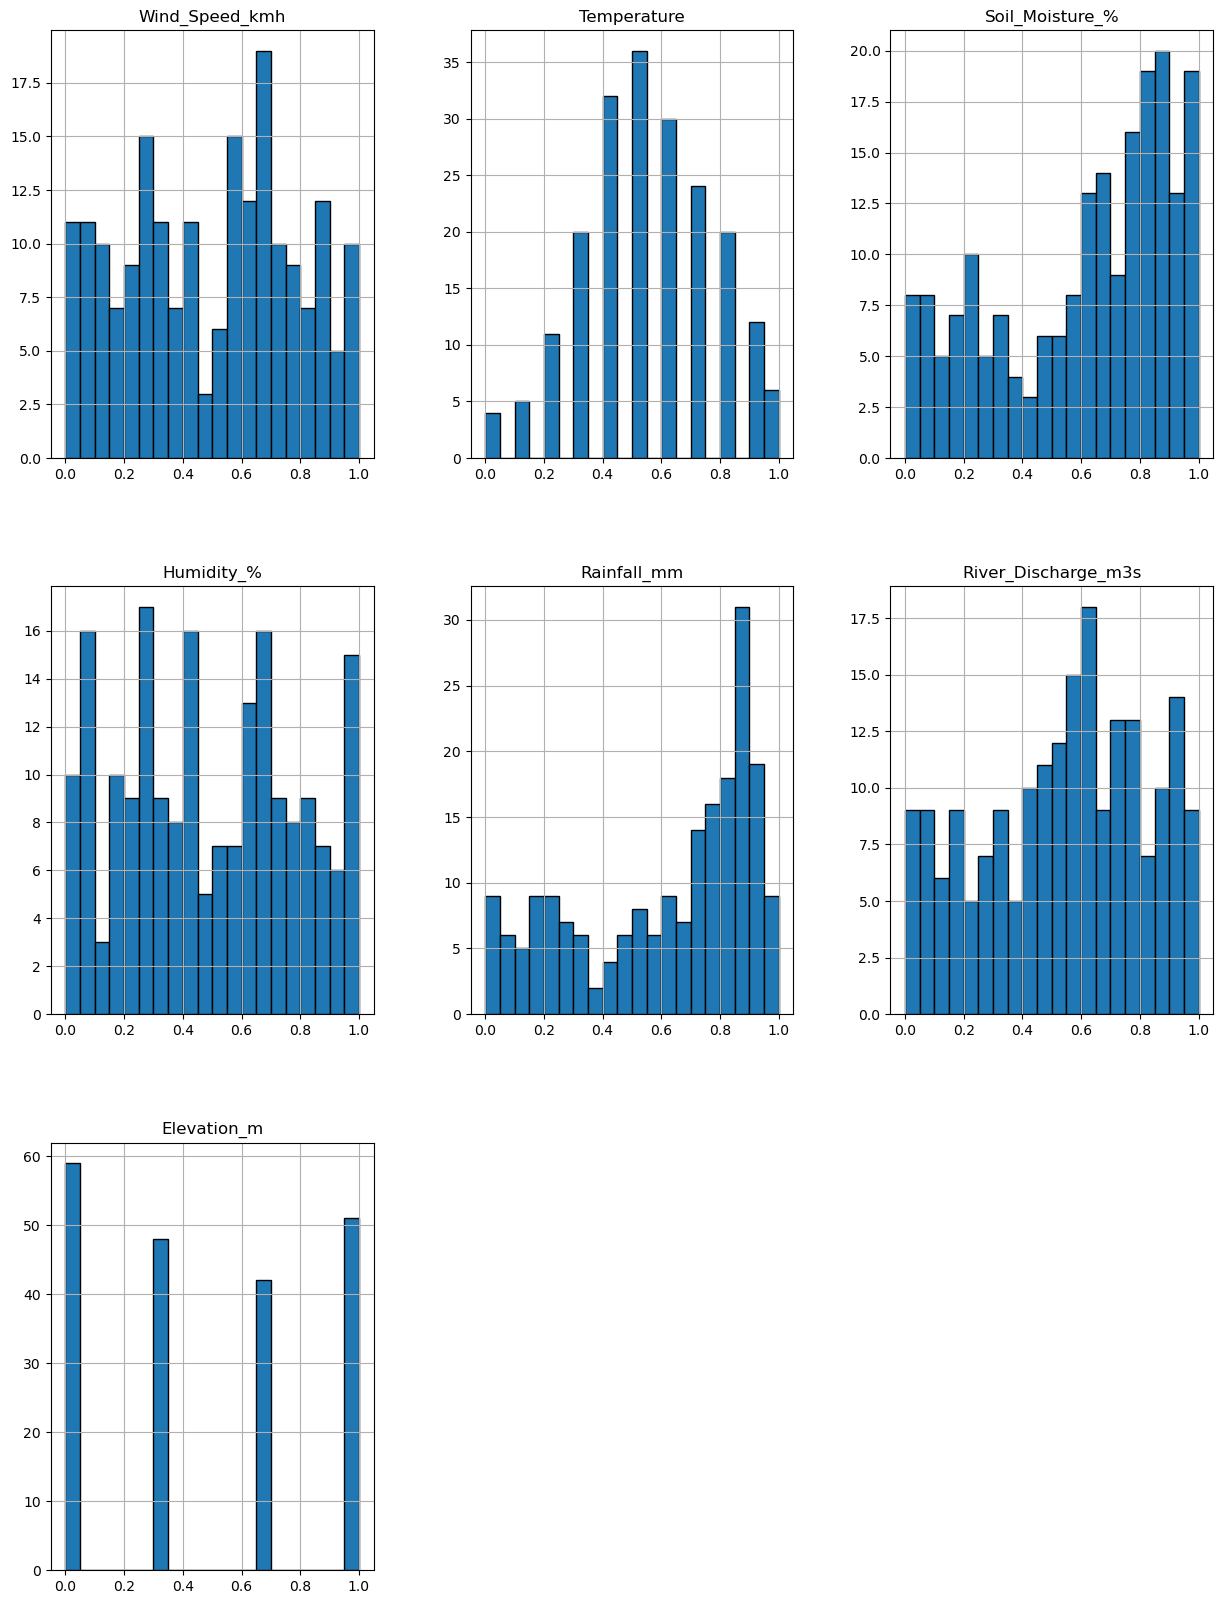

In [25]:
# Plotting Histograms for continuous variables
continous_variables = ['Wind_Speed_kmh','Temperature','Soil_Moisture_%','Humidity_%','Rainfall_mm','River_Discharge_m3s','Elevation_m']
data[continous_variables].hist(bins=20, figsize=(15,20), edgecolor='black')
plot.show()

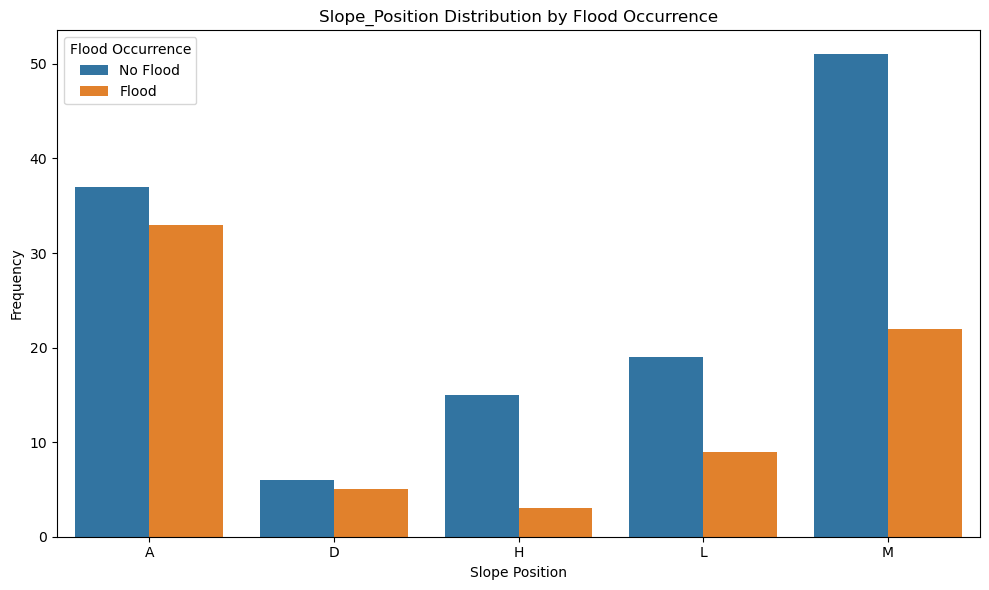

In [26]:
# Mapping for Slope Position
slope_position_mapping = {0:"A",1:"D",2:"H",3:"L",4:"M"}

# Add a new column to the data with mapped values
data['Slope_Label'] = data["Slope_Position"].map(slope_position_mapping)

# Plot using seaborn
plot.figure(figsize=(10,6))
sns.countplot(data=data,x="Slope_Position", hue="Flood_Occurrence")


# Update the x-axis labels with meaningful names
plot.xticks(ticks=range(len(slope_position_mapping)),labels=[slope_position_mapping[pos] for pos in range(len(slope_position_mapping))])

#Add title and labels
plot.title("Slope_Position Distribution by Flood Occurrence")
plot.xlabel("Slope Position")
plot.ylabel("Frequency")
plot.legend(title="Flood Occurrence",labels=["No Flood","Flood"])


#Show plot
plot.tight_layout()
plot.show()


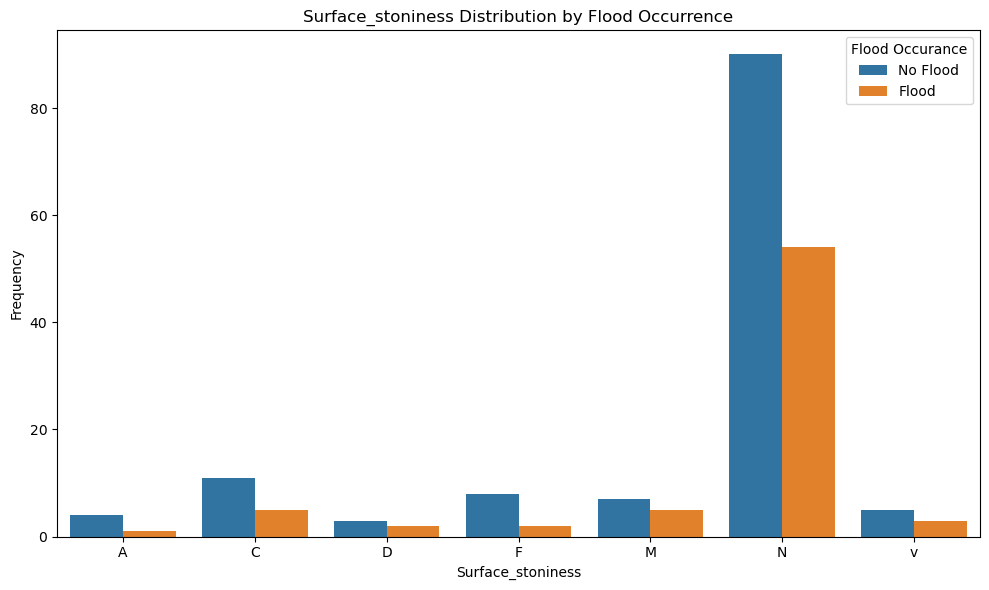

In [27]:
#Mapping Surface_stoniness
surface_stoniness_mapping = {0:"A",1:"C",2:"D",3:"F",4:"M",5:"N",6:"v"}

# Adding New Column with mapped values
data["Surface_Label"] = data["Surface_stoniness"].map(surface_stoniness_mapping)

#Plot using seaborn
plot.figure(figsize=(10,6))
sns.countplot(data=data,x="Surface_stoniness", hue="Flood_Occurrence")

plot.xticks(ticks=range(len(surface_stoniness_mapping)),labels=[surface_stoniness_mapping[pos] for pos in range(len(surface_stoniness_mapping))])

#Add the title and the label
plot.title("Surface_stoniness Distribution by Flood Occurrence")
plot.xlabel("Surface_stoniness")
plot.ylabel("Frequency")
plot.legend(title="Flood Occurance", labels=["No Flood","Flood"])

#show plot
plot.tight_layout()
plot.show()

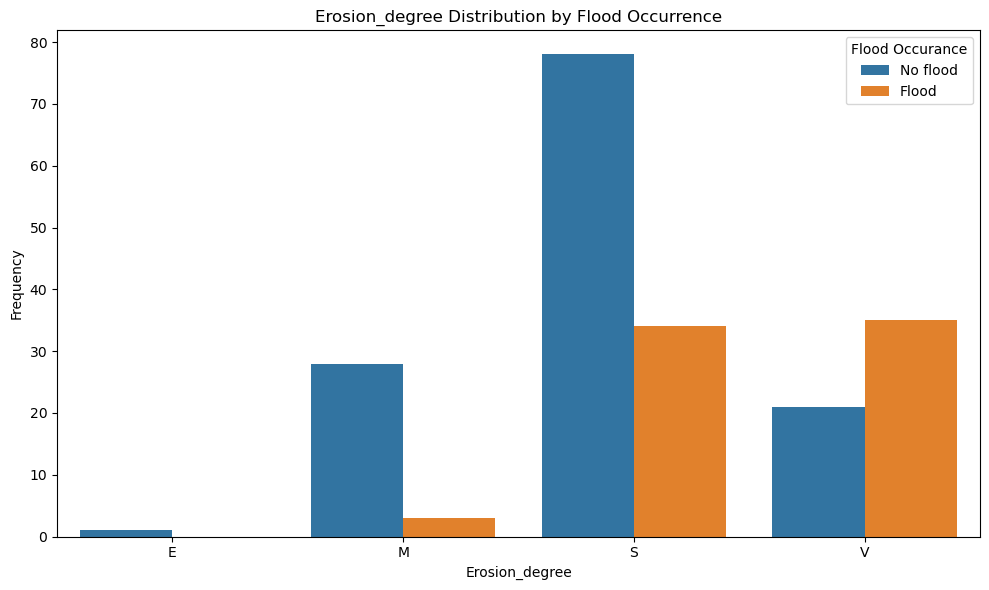

In [28]:
#Mapping for erosion_degree
erosion_degree_mapping = {0:"E",1:"M",2:"S",3:"V"}

# Adding a New Column with mapped values
data["Erosion_Label"] = data["Erosion_degree"].map(erosion_degree_mapping)

#Plot using seaborn
plot.figure(figsize=(10,6))
sns.countplot(data=data,x="Erosion_degree", hue="Flood_Occurrence")

plot.xticks(ticks=range(len(erosion_degree_mapping)),labels=[erosion_degree_mapping[pos] for pos in range(len(erosion_degree_mapping))])

#Add the title and the label
plot.title("Erosion_degree Distribution by Flood Occurrence")
plot.xlabel("Erosion_degree")
plot.ylabel("Frequency")
plot.legend(title="Flood Occurance", labels=["No flood","Flood"])

#show plot
plot.tight_layout()
plot.show()

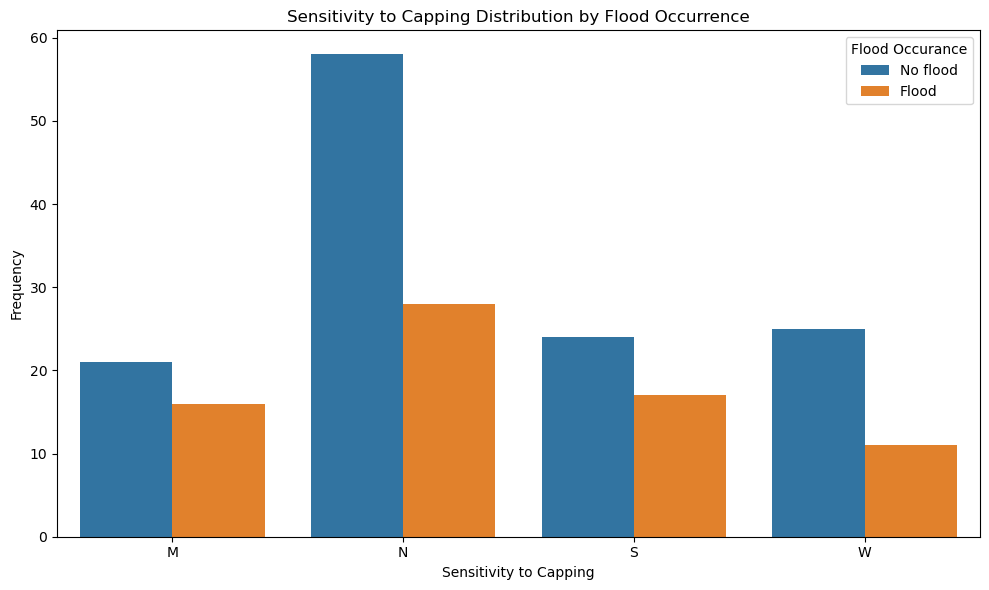

In [29]:
#Mapping for Sensitivity_to_capping
sensitivity_to_capping_mapping = {0:"M",1:"N",2:"S",3:"W"}

# Adding a New Column with mapped values
data["Capping_Label"] = data["Sensitivity_to_capping"].map(sensitivity_to_capping_mapping)

#Plot using seaborn
plot.figure(figsize=(10,6))
sns.countplot(data=data,x="Sensitivity_to_capping", hue="Flood_Occurrence")

plot.xticks(ticks=range(len(sensitivity_to_capping_mapping)),labels=[sensitivity_to_capping_mapping[pos] for pos in range(len(sensitivity_to_capping_mapping))])

#Add the title and the label
plot.title("Sensitivity to Capping Distribution by Flood Occurrence")
plot.xlabel("Sensitivity to Capping")
plot.ylabel("Frequency")
plot.legend(title="Flood Occurance", labels=["No flood","Flood"])

#show plot
plot.tight_layout()
plot.show()

In [30]:
#Convert categorical variables into numeric from using LabelEncoder
label_encoder = LabelEncoder()

# Converting 'Slope_Position' data into numerical values
label_encoder.fit(data["Slope_Position"])
slope_data_encoded =  label_encoder.transform(data['Slope_Position'])
data['Slope_Position'] = slope_data_encoded 

In [31]:
print(data['Slope_Position'])

0      2
1      1
2      2
3      3
4      4
      ..
195    0
196    0
197    0
198    0
199    0
Name: Slope_Position, Length: 200, dtype: int64


In [32]:
#Convert categorical variables into numeric from using LabelEncoder
label_encoder = LabelEncoder()

# Converting Surface Stoniness into numeric values
label_encoder.fit(data['Surface_stoniness'])
stoniness_data_encoded = label_encoder.transform(data['Surface_stoniness'])
data['Surface_stoniness'] = stoniness_data_encoded 

In [33]:
print(data['Surface_stoniness'])

0      5
1      5
2      5
3      5
4      5
      ..
195    5
196    5
197    5
198    5
199    5
Name: Surface_stoniness, Length: 200, dtype: int64


In [34]:
# Converting Erosion Degree into numeric values
label_encoder.fit(data['Erosion_degree'])
erosion_degree_data_encoded = label_encoder.transform(data['Erosion_degree'])
data['Erosion_degree'] = erosion_degree_data_encoded

In [35]:
print(data['Erosion_degree'])

0      2
1      2
2      3
3      3
4      2
      ..
195    2
196    2
197    2
198    3
199    3
Name: Erosion_degree, Length: 200, dtype: int64


In [36]:
# Converting 'Sensitivity to capping' into numeric values
label_encoder.fit(data['Sensitivity_to_capping'])
sensitivity_to_capping_data_encoded = label_encoder.transform(data['Sensitivity_to_capping'])
data['Sensitivity_to_capping'] = sensitivity_to_capping_data_encoded

In [37]:
print(data['Sensitivity_to_capping'])

0      1
1      1
2      1
3      1
4      1
      ..
195    0
196    3
197    2
198    0
199    1
Name: Sensitivity_to_capping, Length: 200, dtype: int64


In [38]:
# Converting 'Land Use Type' into numeric values
label_encoder.fit(data['Land_Use_Type'])
land_use_type_data_encoded = label_encoder.transform(data['Land_Use_Type'])
data['Land_Use_Type'] = land_use_type_data_encoded 

In [39]:
print(data['Land_Use_Type'])

0      1
1      0
2      2
3      0
4      1
      ..
195    3
196    2
197    0
198    2
199    3
Name: Land_Use_Type, Length: 200, dtype: int64


In [40]:
print(data['Slope_Label'])

0      H
1      D
2      H
3      L
4      M
      ..
195    A
196    A
197    A
198    A
199    A
Name: Slope_Label, Length: 200, dtype: object


In [41]:
print(data['Surface_Label'])

0      N
1      N
2      N
3      N
4      N
      ..
195    N
196    N
197    N
198    N
199    N
Name: Surface_Label, Length: 200, dtype: object


In [42]:
print(data['Erosion_Label'])

0      S
1      S
2      V
3      V
4      S
      ..
195    S
196    S
197    S
198    V
199    V
Name: Erosion_Label, Length: 200, dtype: object


In [43]:
print(data['Capping_Label'])

0      N
1      N
2      N
3      N
4      N
      ..
195    M
196    W
197    S
198    M
199    N
Name: Capping_Label, Length: 200, dtype: object


In [44]:
# Columns to drop to get correlation matrix
columns_to_drop = ['Slope_Label','Surface_Label','Erosion_Label','Capping_Label']

In [45]:
filtered_data = data.drop(columns=columns_to_drop)

In [46]:
correlation_matrix = filtered_data.corr()
print(correlation_matrix)

                        Slope_Position  Surface_stoniness  Area_affected  \
Slope_Position                1.000000          -0.044937      -0.076768   
Surface_stoniness            -0.044937           1.000000      -0.064388   
Area_affected                -0.076768          -0.064388       1.000000   
Erosion_degree               -0.067481           0.067319       0.321233   
Sensitivity_to_capping        0.006594          -0.069304       0.075746   
Wind_Speed_kmh               -0.101181          -0.005089       0.086432   
Temperature                  -0.130091          -0.175863      -0.044003   
Soil_Moisture_%              -0.017874          -0.033396      -0.022979   
Humidity_%                   -0.028015          -0.003057       0.020152   
Rainfall_mm                  -0.107174           0.061356      -0.004982   
River_Discharge_m3s          -0.108476           0.020694       0.019657   
Land_Use_Type                 0.063596           0.029549      -0.195324   
Elevation_m 

In [47]:
print(correlation_matrix['Flood_Occurrence'].sort_values(ascending=False))

Flood_Occurrence          1.000000
Rainfall_mm               0.608526
Soil_Moisture_%           0.519057
River_Discharge_m3s       0.484573
Erosion_degree            0.371743
Land_Use_Type             0.163922
Humidity_%                0.088232
Temperature               0.085316
Elevation_m               0.084449
Surface_stoniness         0.066542
Area_affected             0.058898
Wind_Speed_kmh            0.044432
Sensitivity_to_capping   -0.046219
Slope_Position           -0.156961
Name: Flood_Occurrence, dtype: float64


In [48]:
# Drop duplicate rows
filtered_data=filtered_data.drop_duplicates()

In [49]:
correlation_matrix = filtered_data.corr()
print(correlation_matrix)

                        Slope_Position  Surface_stoniness  Area_affected  \
Slope_Position                1.000000          -0.044937      -0.076768   
Surface_stoniness            -0.044937           1.000000      -0.064388   
Area_affected                -0.076768          -0.064388       1.000000   
Erosion_degree               -0.067481           0.067319       0.321233   
Sensitivity_to_capping        0.006594          -0.069304       0.075746   
Wind_Speed_kmh               -0.101181          -0.005089       0.086432   
Temperature                  -0.130091          -0.175863      -0.044003   
Soil_Moisture_%              -0.017874          -0.033396      -0.022979   
Humidity_%                   -0.028015          -0.003057       0.020152   
Rainfall_mm                  -0.107174           0.061356      -0.004982   
River_Discharge_m3s          -0.108476           0.020694       0.019657   
Land_Use_Type                 0.063596           0.029549      -0.195324   
Elevation_m 

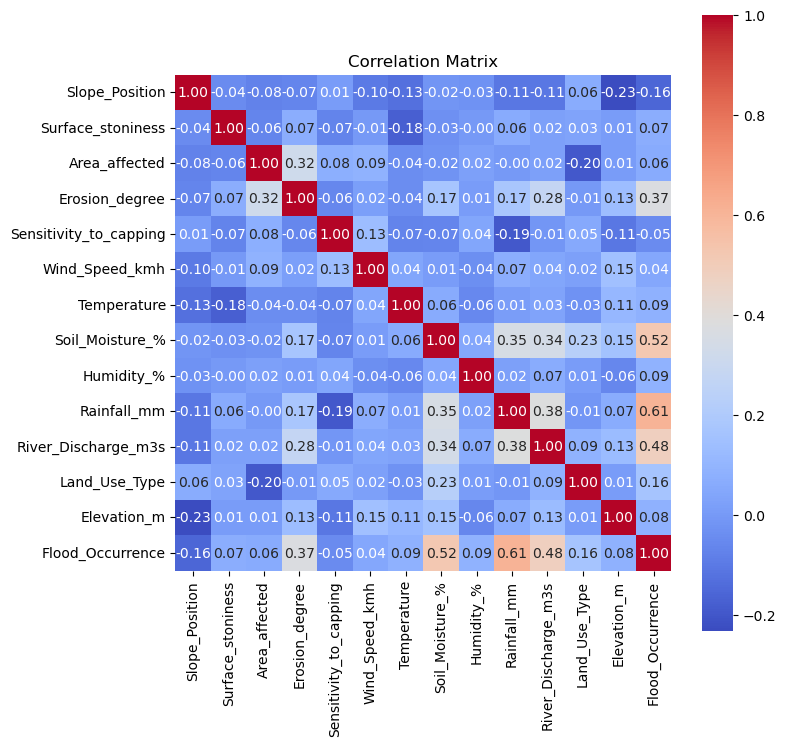

In [50]:
plot.figure(figsize=(8,8))
sns.heatmap(correlation_matrix, vmax=1, annot=True, square=True, fmt=".2f", cmap="coolwarm", cbar=True)
plot.title("Correlation Matrix", fontsize=12)
plot.show()

In [51]:
# Removes the Flood_Occurance from independent variables x-axis 
# since it is not a factor in determining
# it is not a a predictor
X = filtered_data.drop(columns=['Flood_Occurrence'])
y = filtered_data['Flood_Occurrence']

# Split data into training and testing sets

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("XTrains->",X_train.shape[0],"XTest->",X_test.shape[0],"YTrain->",y_test.shape[0],"YTest->",y_test.shape[0])

XTrains-> 140 XTest-> 60 YTrain-> 60 YTest-> 60


# 1. Random Forest

In [55]:
rmf_model = RandomForestClassifier(max_depth=3,random_state=0)
rmf_classifier = rmf_model.fit(X_train.values,y_train.values)
rmf_classifier

RandomForestClassifier(max_depth=3, random_state=0)

In [56]:
x_train_std = scaler.fit_transform(X_train)
x_test_std = scaler.transform(X_test)

In [57]:
# from sklearn.model_selection import cross_val_score
rmf_classiffier_accuracy = cross_val_score(rmf_classifier,x_train_std,y_train,cv=3,scoring="accuracy",n_jobs=-1)

In [58]:
rmf_classiffier_accuracy

array([0.89361702, 0.82978723, 0.84782609])

In [59]:
rf_scores = []
estimators = [10,20,100,200,500]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators=1, random_state = 0)
    rf_classifier.fit(X_train.values, y_train.values)
    rf_scores.append(round(rf_classifier.score(X_test.values, y_test.values),2))

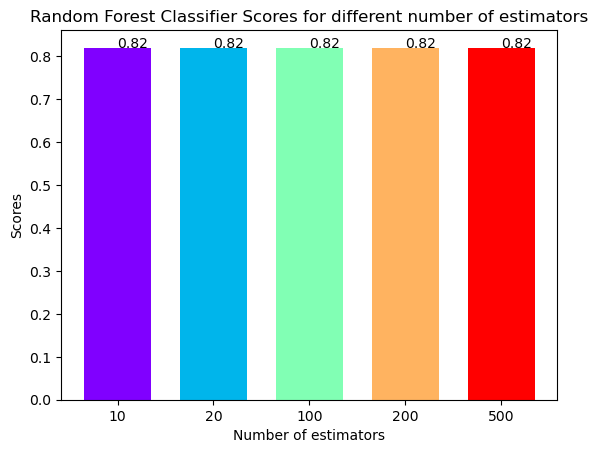

In [60]:
colors = rainbow(np.linspace(0,1,len(estimators)))
plot.bar([i for i in range(len(estimators))],rf_scores, color=colors, width = 0.7)
for i in range(len(estimators)):
    plot.text(i, rf_scores[i], rf_scores[i])
plot.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plot.xlabel('Number of estimators')
plot.ylabel('Scores')
plot.title('Random Forest Classifier Scores for different number of estimators')
plot.show()

In [61]:
# Replace NaN with column mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [62]:
y_pred = rmf_classifier.predict(X_test)


accuracy score:93.333333
recall score:85.714286
roc score:91.575092
F1 Score: 0.9


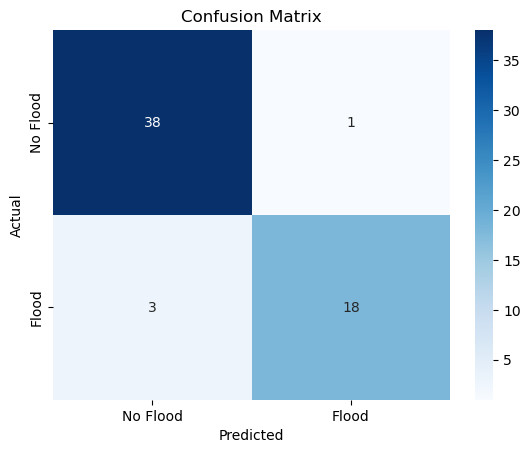

In [63]:
# Getting a confusion matrix
print("\naccuracy score:%f"%(accuracy_score(y_test,y_pred)*100))
print("recall score:%f"%(recall_score(y_test,y_pred)*100))
print("roc score:%f"%(roc_auc_score(y_test,y_pred)*100))

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plot.xlabel('Predicted')
plot.ylabel('Actual')
plot.title('Confusion Matrix')
plot.show()

# 2. K Nearest Neighbours

In [65]:
# from sklearn import model_selection,neighbors
classifier = neighbors.KNeighborsClassifier()
knn_classifier = classifier.fit(X_train,y_train)

In [66]:
#Predict chances of flood
y_predict = knn_classifier.predict(X_test)
print('Predicted chances of flood')
print(y_predict)

Predicted chances of flood
[0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0
 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1]


In [67]:
#Actual chances of flood
print("Actual values of floods:")
print(y_test)

Actual values of floods:
95     0
15     1
30     0
158    0
128    0
115    1
69     0
170    0
174    0
45     0
66     0
182    1
165    1
78     0
186    0
177    1
56     1
152    1
82     1
68     1
124    0
16     0
148    0
93     0
65     0
60     1
84     0
67     0
125    0
132    0
9      0
18     0
55     0
75     0
150    1
104    0
135    1
137    0
164    1
76     0
79     1
197    1
38     0
24     1
122    0
195    1
29     0
19     1
143    0
86     0
114    0
173    1
5      0
126    0
117    0
73     0
140    1
98     0
172    0
96     1
Name: Flood_Occurrence, dtype: int64



accuracy score:63.333333
recall score:47.619048
roc score:59.706960
F1 Score: 0.47619047619047616


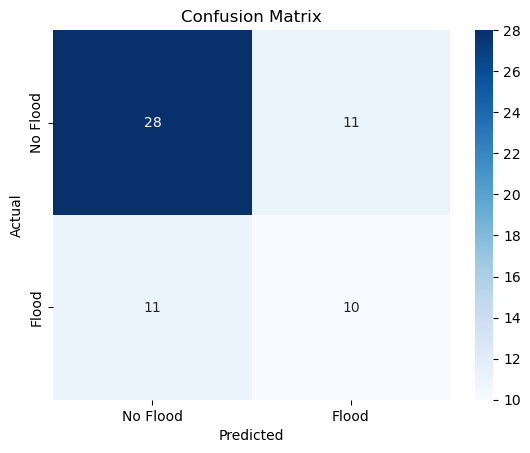

In [68]:
knn_accuracy = cross_val_score(knn_classifier,X_test,y_test,cv=3,scoring='accuracy',n_jobs=-1)
knn_accuracy.mean()
print("\naccuracy score:%f"%(accuracy_score(y_test,y_predict)*100))
print("recall score:%f"%(recall_score(y_test,y_predict)*100))
print("roc score:%f"%(roc_auc_score(y_test,y_predict)*100))
# Calculate F1 Score
f1 = f1_score(y_test, y_predict)
print(f'F1 Score: {f1}')

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plot.xlabel('Predicted')
plot.ylabel('Actual')
plot.title('Confusion Matrix')
plot.show()

# K-Nearest Neighbors Model

In [70]:
knn_scores = []
for k in range(2,21):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier.fit(X_train.values, y_train.values)
    knn_score = round(knn_classifier.score(X_test.values, y_test.values),2)
    knn_scores.append(knn_score)


knn_classifier = KNeighborsClassifier(n_neighbors = 5)
knn_classifier.fit(X_train, y_train)
knn_score = knn_classifier.predict(X_test)
print(classification_report(y_test,knn_score))
print('Accuracy : ',accuracy_score(y_test,y_predict)*100)
print('Recall score : ',recall_score(y_test,y_predict)*100)
print('ROC score : ',roc_auc_score(y_test,y_predict)*100)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        39
           1       0.48      0.48      0.48        21

    accuracy                           0.63        60
   macro avg       0.60      0.60      0.60        60
weighted avg       0.63      0.63      0.63        60

Accuracy :  63.33333333333333
Recall score :  47.61904761904761
ROC score :  59.70695970695971


In [71]:
knn_accuracy = cross_val_score(knn_classifier,X_test,y_test,cv=3,scoring='accuracy',n_jobs=-1)
knn_accuracy.mean()
print("\naccuracy score:%f"%(accuracy_score(y_test,y_predict)*100))
print("recall score:%f"%(recall_score(y_test,y_predict)*100))
print("roc score:%f"%(roc_auc_score(y_test,y_predict)*100))
# Calculate F1 Score
f1 = f1_score(y_test, y_predict)
print(f'F1 Score: {f1}')


accuracy score:63.333333
recall score:47.619048
roc score:59.706960
F1 Score: 0.47619047619047616


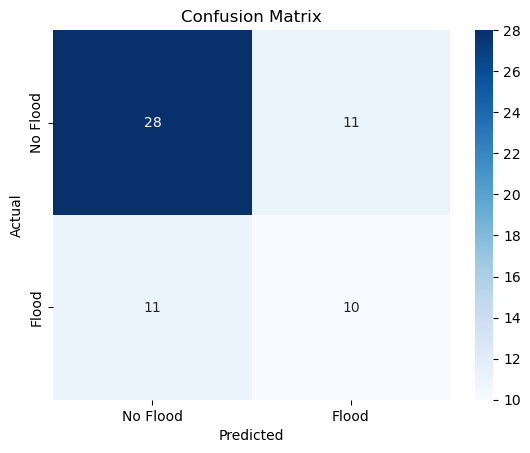

In [72]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plot.xlabel('Predicted')
plot.ylabel('Actual')
plot.title('Confusion Matrix')
plot.show()

# KNN Plot

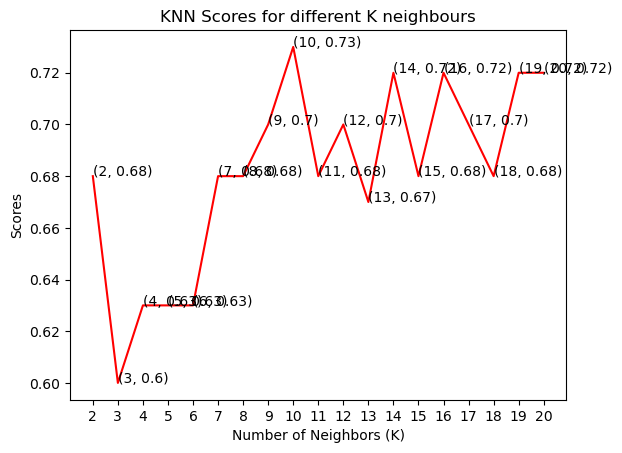

In [74]:
plot.plot([k for k in range(2,21)], knn_scores, color = 'red')
for i in range(2, 21):
    plot.text(i, knn_scores[i-2],(i, knn_scores[i-2]))

plot.xticks([i for i in range(2,21)])
plot.xlabel('Number of Neighbors (K)')
plot.ylabel('Scores')
plot.title("KNN Scores for different K neighbours")
plot.show()

In [75]:
knn_classifier = KNeighborsClassifier(n_neighbors = 11)
knn_classifier.fit(X_train.values, y_train.values)
check_data_bix = np.array([[52,1,0,125,212,0,1,168,0,1,2,2,3]])
prediction_result = knn_classifier.predict(check_data_bix)
print(f"Prediction {prediction_result}")

Prediction [1]


# 3. Logistic Regression Model

In [77]:
logistic_regression_model = LogisticRegression()
logistic_regression_classifier = logistic_regression_model.fit(x_train_std,y_train)
logistic_regression_accuracy = cross_val_score(logistic_regression_classifier,x_test_std,y_test,cv=3,scoring='accuracy',n_jobs=-1)

In [78]:
y_predict = logistic_regression_classifier.predict(x_test_std)

In [79]:
print("\naccuracy score: %f"%(accuracy_score(y_test,y_predict)*100))
print("recall score: %f"%(recall_score(y_test,y_predict)*100))
print("roc score: %f"%(roc_auc_score(y_test,y_predict)*100))
f1 = f1_score(y_test, y_predict)
print(f'F1 Score: {f1}')


accuracy score: 90.000000
recall score: 76.190476
roc score: 86.813187
F1 Score: 0.8421052631578947


In [80]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
#                     epochs=100, batch_size=32, callbacks=[early_stopping, model_checkpoint])

# Logistic Regression (b)

In [83]:
# logistic_model = LogisticRegression()
# logistic_model.fit(X_train.values, y_train.values)
# logistic_model_prediction = logistic_model.predict(X_test.values)
# print(accuracy_score(y_test.values, logistic_model_prediction))
# print(classification_report(y_test.values,logistic_model_prediction))

# Support Vector Machine

In [85]:
svc_scores = []
kernels = ['linear','poly','rbf','sigmoid']
for i in range(len(kernels)):
    svc_classifier = SVC(kernel = kernels[i])
    svc_classifier.fit(X_train.values, y_train.values)
    svc_scores.append(round(svc_classifier.score(X_test.values,y_test.values),2))

support_vector_model = SVC(kernel = kernels[0])
support_vector_model.fit(X_train.values, y_train.values)
svc_prediction_result = support_vector_model.predict(X_test.values)
# print(f"Support Vector Prediction results {svc_prediction_result}")
svc_accuracy = accuracy_score(y_test.values,svc_prediction_result)
print(f"Support Vector Model Accuracy is {svc_accuracy}")

Support Vector Model Accuracy is 0.9


# Support Vector Plot

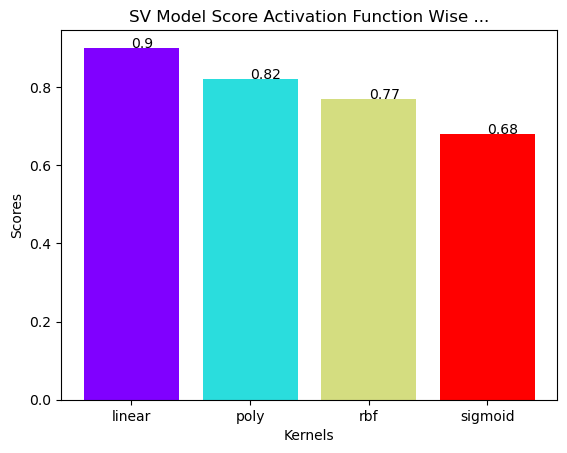

In [87]:
colors = rainbow(np.linspace(0,1, len(kernels)))
plot.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plot.text(i, svc_scores[i], svc_scores[i])
plot.xlabel("Kernels")
plot.ylabel("Scores")
plot.title("SV Model Score Activation Function Wise ...")
plot.show()

# Artificial Neural Network Model

In [89]:
ann_model = Sequential()
ann_model.add(Dense(units = 64, activation = 'relu', input_dim=X_train.shape[1]))
ann_model.add(Dense(units = 32, activation = 'relu'))
ann_model.add(Dense(units=1))

# Compile Model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model 
history = ann_model.fit(X_train.values, y_train.values, epochs=100, batch_size=32, validation_split=0.2)

#Evaluate the model
loss = ann_model.evaluate(X_test.values, y_test.values)
print(f"Test Loss: {loss}")

# Make Predictions
y_predict = ann_model.predict(X_test.values)

print(f"ANN Prediction: {y_predict}")

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2278 - val_loss: 0.2162
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2263 - val_loss: 0.2062
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1829 - val_loss: 0.2091
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1616 - val_loss: 0.1898
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1395 - val_loss: 0.1882
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1417 - val_loss: 0.1903
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1308 - val_loss: 0.1945
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1225 - val_loss: 0.1839
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1099 - val_loss: 0.1822
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1195 - val_loss: 0.1810
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1109 - val_loss: 0.1749
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1045 - val_loss: 0.1726

# Plotting the ANN Model Results

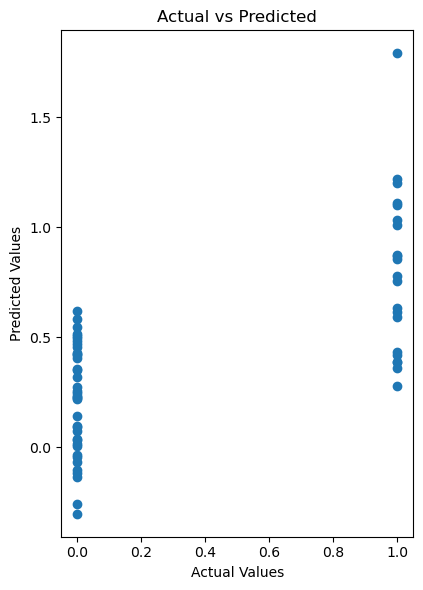

In [91]:
plot.figure(figsize=(8,6))
plot.subplot(1,2,2)
plot.scatter(y_test, y_predict)
plot.xlabel('Actual Values')
plot.ylabel('Predicted Values')
plot.title('Actual vs Predicted')

plot.tight_layout()
plot.show()


## Save the random forest model 

In [176]:
import pickle 
pickle.dump(rmf_model,open('./models/model.pkl','wb'))
pickle.dump(ann_model,open('./models/ann_model.pkl','wb'))
pickle.dump(support_vector_model,open('./models/svc_model.pkl','wb'))
pickle.dump(logistic_regression_model,open('./models/lr_model.pkl','wb'))
    

## Save the accurate models to file

In [178]:
open_file = open("./models/model.pkl","rb")
ann_open_file = open("./models/ann_model.pkl","rb")
svc_open_file = open("./models/svc_model.pkl","rb")
lr_open_file = open("./models/lr_model.pkl","rb")

RF_model = pickle.load(open_file)
ANN_model = pickle.load(ann_open_file)
SVC_model = pickle.load(svc_open_file)
LR_model = pickle.load(lr_open_file)

print(RF_model)
print(ANN_model)
print(SVC_model)
print(LR_model)
print("Done")

RandomForestClassifier(max_depth=3, random_state=0)
<Sequential name=sequential, built=True>
SVC(kernel='linear')
LogisticRegression()
Done
